#### Analysis to do in one dataset

For each model, analyze if more components lead to a better performance.

For each model, and each number of components analyze which DR method leads to a better performance.

For each type of model, analyze 


#### Extra analysis

Compare the behavior of each experiment with and without class balancing. 

# Imports

In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
# import plotly.graph_objs as go
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import f_oneway
from scipy.stats import ttest_ind, ttest_rel

# Functions and Labels


In [10]:
LABELS = {
    "Salinas": [
        "Undefined",
        "Brocoli_green_weeds_1",
        "Brocoli_green_weeds_2",
        "Fallow",
        "Fallow_rough_plow",
        "Fallow_smooth",
        "Stubble",
        "Celery",
        "Grapes_untrained",
        "Soil_vinyard_develop",
        "Corn_senesced_green_weeds",
        "Lettuce_romaine_4wk",
        "Lettuce_romaine_5wk",
        "Lettuce_romaine_6wk",
        "Lettuce_romaine_7wk",
        "Vinyard_untrained",
        "Vinyard_vertical_trellis",
    ],

    'IndianPines': [
        "Undefined",
        "Alfalfa",
        "Corn-notill",
        "Corn-mintill",
        "Corn",
        "Grass-pasture",
        "Grass-trees",
        "Grass-pasture-mowed",
        "Hay-windrowed",
        "Oats",
        "Soybean-notill",
        "Soybean-mintill",
        "Soybean-clean",
        "Wheat",
        "Woods",
        "Buildings-Grass-Trees-Drives",
        "Stone-Steel-Towers",
    ]}


def filter_exp_by_substring(df, substrings):
    mask = df['Experiment'].apply(lambda x: any(substring in x for substring in substrings))
    filtered_df = df[mask]
    return filtered_df

# def show_confusion_matrix(confusion_matrix, labels, normalize=False):
#     if normalize:
#         confusion_matrix = normalize_confusion_matrix(confusion_matrix)

#     fig = px.imshow(confusion_matrix, text_auto=True, 
#                     labels=dict(x='Predicted labels', y='Actual labels', color='# of classification'),
#                     x = labels,
#                     y = labels,
#                     height=700
#                     )
#     fig.update_xaxes(tickangle=45, type='category')
#     fig.show()

def show_confusion_matrix(confusion_matrix, labels, normalize=False):
    if normalize:
        confusion_matrix = normalize_confusion_matrix(confusion_matrix)

    fig = go.Figure()

    fig.add_trace(
        go.Heatmap(z=confusion_matrix,  
                   colorscale='Blues', 
                   showscale=False,
                   x=labels, 
                   y=labels,  
                   zmin=0, 
                   zmax=1 if normalize else None,
                   colorbar=dict(title='Normalized' if normalize else 'Counts'))
    )

    fig.update_xaxes(title='Predicted labels', tickangle=45, type='category')
    fig.update_yaxes(title='Actual labels', type='category')

    fig.update_layout(
        title='Confusion Matrix',
        height=800,
        width=800,
        showlegend=False
    )

    fig.show()



def show_confusion_matrices(df_results, exps, labels, normalize=False):
    confusion_matrices = []
    for exp in exps:
        confusion_matrices.append(df_results[df_results['Experiment'] == exp]['Confusion matrix'].values[0])

    fig = make_subplots(rows=2, cols=2, subplot_titles=exps)

    for i, (confusion_matrix, label) in enumerate(zip(confusion_matrices, labels)):
        if normalize:
            confusion_matrix = normalize_confusion_matrix(confusion_matrix)

        row = i // 2 + 1
        col = i % 2 + 1

        fig.add_trace(
            go.Heatmap(z=confusion_matrix, colorscale='Blues', showscale=False,
                       x=labels, y=labels, zmin=0, zmax=1 if normalize else None,
                       colorbar=dict(title='Normalized' if normalize else 'Counts')),
            row=row, col=col
        )

        # fig.update_xaxes(tickangle=45, type='category', row=row, col=col)
        # if col == 2:  # Only update y-axis for the second subplot
        #     fig.update_yaxes(showticklabels=False, row=row, col=col)

        if row == 2:
            fig.update_xaxes(title='Predicted labels', tickangle=45, type='category', row=row, col=col)
        else:
            fig.update_xaxes(showticklabels=False, row=row, col=col)
        
        if col == 1:
            fig.update_yaxes(title='Actual labels', type='category', row=row, col=col)
        else:
            fig.update_yaxes(showticklabels=False, row=row, col=col)
    
    fig.update_layout(
        title='Confusion Matrices',
        height=1000,
        width=1000,
        showlegend=False
    )

    fig.show()


def normalize_confusion_matrix(conf_matrix):
    class_totals = np.sum(conf_matrix, axis=1)
    normalized_conf_matrix = conf_matrix / class_totals[:, np.newaxis]
    return np.round(normalized_conf_matrix, 2)


def plot_acc_by_model(df):
    # Parse 'Experiment' column to extract model information
    df['Model'] = df['Experiment'].apply(lambda x: x.split('_')[-1])
    unique_models = df['Model'].unique()

    colors = px.colors.qualitative.Plotly[:len(unique_models)]

    data = []
    for model, color in zip(unique_models, colors):
        model_data = df[df['Model'] == model]
        trace = go.Bar(
            x=model_data['Experiment'],  
            y=model_data['Accuracy'], 
            name=model, 
            marker=dict(color=color) 
        )
        data.append(trace)

    fig = go.Figure(data=data)

    fig.update_layout(
        title='Accuracies of Different Models',
        xaxis=dict(title='Experiment'),
        yaxis=dict(title='Accuracy (%)', range=[0, 100]),  
        barmode='group',  
        # template='plotly_white'  # White background template
    )

    fig.update_layout(showlegend=True)
    fig.show()


def plot_grouped_values(df_results, labels, metric):
    traces = []
    for i, experiment in enumerate(df_results['Experiment']):
        experiment_iou = df_results[metric].values[i]
        trace = go.Bar(
            x=labels,  
            y=experiment_iou, 
            name=experiment  
        )
        traces.append(trace)

    layout = go.Layout(
        title=f'{metric} Values by Experiment',
        xaxis=dict(title='Class'),
        yaxis=dict(title=metric),
        barmode='group'  # Grouped bars
    )

    fig = go.Figure(data=traces, layout=layout)
    fig.show()


def accuracies_by_n_comps(df, dataset, dr_method):
    accuracy_df = filter_exp_by_substring(df, [f'{dataset}_{dr_method}_'])[['N Components', 'Model', 'Accuracy']]

    accuracy_df = accuracy_df.pivot(index='Model', columns='N Components', values='Accuracy')
    accuracy_df.__doc__ = f"Accuracy values in {dataset} using {dr_method}"
    return accuracy_df


def ANOVA_TTest(df_accuracies, transposed=False, describe=False, ind_samples=False):
    if transposed:
        df_accuracies = df_accuracies.transpose()
    
    # print(df_accuracies)
    if describe:
        print(df_accuracies.describe().loc[['mean', 'std', 'max']])    

    # Perform ANOVA
    f_statistic, p_value = f_oneway(*df_accuracies.values)
    print(f'ANOVA test -> F-statistic: {f_statistic}, p-value: {p_value}')
    
    if p_value < 0.05:
        ANOVA_diff = True
        print("ANOVA indicates a significant difference in accuracies.")
    else:
        ANOVA_diff = False
        print("No significant difference in accuracies for ANOVA")

    print('\nPaired T Tests')

    # Perform paired t-tests
    found = False
    differences = []
    for i in range(len(df_accuracies)):
        for j in range(i+1, len(df_accuracies)):
            data1 = df_accuracies.iloc[i]
            data2 = df_accuracies.iloc[j]
            if ind_samples:
                t_statistic, p_value = ttest_rel(data1, data2)
            else:
                t_statistic, p_value = ttest_rel(data1, data2)
            print(f"{df_accuracies.index[i]} vs {df_accuracies.index[j]}: t-statistic = {t_statistic}, p-value = {p_value}")
            if p_value < 0.05:
                found = True
                if data1.mean() > data2.mean():
                    difference = f"THERE IS A SIGNIFICANT DIFFERENCE in accuracies in favor of {df_accuracies.index[i]} over {df_accuracies.index[j]}."
                    # print(difference)
                    differences.append(f'{df_accuracies.index[i]} > {df_accuracies.index[j]}')
                else:
                    difference = f"THERE IS A SIGNIFICANT DIFFERENCE in accuracies in favor of {df_accuracies.index[j]} over {df_accuracies.index[i]}."
                    # print(difference)
                    differences.append(f'{df_accuracies.index[j]} > {df_accuracies.index[i]}')

            # else:
                # print(f"There is NO SIGNIFICANT DIFFERENCE in accuracies between {df_accuracies.index[i]} and {df_accuracies.index[j]}.")
    if differences == []:
        print("\nNo significant difference found with T Tests")
    return ANOVA_diff, differences

def paired_t_test(df_accuracies):
 # Perform paired t-tests
    found = False
    differences = []

    data1 = df_accuracies.iloc[0]
    data2 = df_accuracies.iloc[1]
    t_statistic, p_value = ttest_rel(data1, data2)
    # print(f"\n{df_accuracies.index[0]} vs {df_accuracies.index[1]}: t-statistic = {t_statistic}, p-value = {p_value}")
    if p_value < 0.05:
        found = True
        if data1.mean() > data2.mean():
            return df_accuracies.iloc[0].name
        else:
            return df_accuracies.iloc[1].name
    return '='


def scores_by_model(df, dataset, dr_method, n_comps, scores):
    if scores == 'F1':
        scores_df = filter_exp_by_substring(df, [f'{dataset}_{dr_method}_'])[['N Components', 'Model', 'F1 scores']]
        scores_df = scores_df.pivot(index='Model', columns='N Components', values='F1 scores')
    elif scores == 'IOU':
        scores_df = filter_exp_by_substring(df, [f'{dataset}_{dr_method}_'])[['N Components', 'Model', 'IOU']]
        scores_df = scores_df.pivot(index='Model', columns='N Components', values='IOU')

    scores_df.__doc__ = f"{scores} scores values in {dataset} using {dr_method}"

    df_flat = pd.concat([scores_df[n_comps], scores_df[n_comps].apply(pd.Series)], axis=1)
    df_flat.drop(columns=[n_comps], inplace=True)
    df_flat.columns = [f'Class {i+1}' for i in range(len(df_flat.columns))]
    
    return df_flat


import seaborn as sns
import matplotlib.pyplot as plt

def plot_sorted_column_heatmap(df, column_name):
    """
    Plot a specified column of a DataFrame as a heatmap, sorted by another column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot as a heatmap.
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Sort the DataFrame by the specified column
    df_sorted = df.sort_values(by=column_name, ascending=False)
    
    # Create the heatmap
    plt.figure(figsize=(1, 8))  # Adjust figsize as necessary
    sns.heatmap(df_sorted[[column_name]], cmap='Spectral', cbar=False, annot=True, vmin=0, vmax=100)
    
    # Set y-axis labels to the experiment names
    plt.yticks(ticks=np.arange(df_sorted.shape[0]) + 0.5, labels=df_sorted['Experiment'], rotation=0)  # Use shape[0] for the number of rows
    
    # Set plot labels and title
    plt.ylabel('Experiment')
    plt.title(f'{column_name}')
    plt.show()




# Loading Results and Preparing DataFrame

In [11]:
dict_models = {
    'hamida': 'Deep CNN', 
    'li': 'Shallow CNN', 
    'paoletti': 'Deep RNN', 
    'Mou': 'Shallow RNN'
}

dict_results = {}
for ds in ['Salinas', 'IndianPines']:
# for ds in ['IndianPines']:

    for dr_method in ['PCA', 'FastICA', 'UMAP', 'DiffMaps', 'SOM', 'Corr', 'Var', 'AE1', 'AE2',
                       'PCA-Split', 'FastICA-Split', 'UMAP-Split']:
    # for dr_method in ['AE1', 'AE2']:

        for n_components in [8, 15, 30]:
            for model in ['mou', 'hamida', 'li', 'paoletti']:
                filename = f'{ds}_{dr_method}_{n_components}_{model}_30epochs.csv'
                print('\n' + filename)

                try:
                    df = pd.read_csv(f'./Results/Not Balanced/{model}/{filename}', index_col=0)
                    # df = pd.read_csv(f'./Results/Class Balancing/{model}/{filename}', index_col=0)

                    print('Loaded.')
                    try:
                        df['Confusion matrix'] = df['Confusion matrix'].apply(lambda x: pickle.loads(eval(x)))
                        df['F1 scores'] = df['F1 scores'].apply(lambda x: pickle.loads(eval(x)))
                        df['IOU'] = df['IOU'].apply(lambda x: pickle.loads(eval(x)))
                        dict_results[f'{ds}_{dr_method}_{n_components}_{model}'] = df
                        print('Columns unpickled.')
                    except:
                        print("Problem with pickled columns")
                except:
                    print("Couldn't find CSV file.")
                
dfs = []
for key, value in dict_results.items():
    df = pd.DataFrame(value)
    df.insert(0, 'Experiment', key)  # Inserting the 'Method' column as the first column
    dfs.append(df)

# Concatenate all DataFrames
df_results = pd.concat(dfs, ignore_index=True)
df_results['Dataset'] = df_results['Experiment'].apply(lambda x: x.split('_')[0])
df_results['DR Method'] = df_results['Experiment'].apply(lambda x: x.split('_')[1])
df_results['N Components'] = df_results['Experiment'].apply(lambda x: int(x.split('_')[2]))
df_results['Model'] = df_results['Experiment'].apply(lambda x: '_'.join(x.split('_')[3:]))
df_results


Salinas_PCA_8_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_8_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_8_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_8_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_15_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_PCA_30_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_mou_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_hamida_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_li_30epochs.csv
Loaded.
Columns unpickled.

Salinas_FastICA_8_paoletti_30epochs.csv
Loaded.
Columns unpickled.

Sal

,Experiment,Confusion matrix,Accuracy,F1 scores,Kappa,IOU,Dataset,DR Method,N Components,Model
0,Salinas_PCA_8_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.285337,"[0.0, 0.9757838388988019, 1.0, 0.9977266986612...",0.947651,"[0.0, 0.9527127924340468, 1.0, 0.9954637096774...",Salinas,PCA,8,mou
1,Salinas_PCA_8_hamida,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",94.708936,"[0.0, 0.9757838388988019, 1.0, 0.9992414664981...",0.941174,"[0.0, 0.9527127924340468, 1.0, 0.9984840828701...",Salinas,PCA,8,hamida
2,Salinas_PCA_8_li,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.701011,"[0.0, 0.9757838388988019, 1.0, 0.9997470275739...",0.952256,"[0.0, 0.9527127924340468, 1.0, 0.9994941831057...",Salinas,PCA,8,li
3,Salinas_PCA_8_paoletti,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.536589,"[0.0, 0.9757838388988019, 1.0, 0.9929149797570...",0.950400,"[0.0, 0.9527127924340468, 1.0, 0.9859296482412...",Salinas,PCA,8,paoletti
4,Salinas_PCA_15_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",88.488611,"[0.0, 0.9612202688728024, 0.9907914053116241, ...",0.872189,"[0.0, 0.925335988053758, 0.9817508595609628, 0...",Salinas,PCA,15,mou
...,...,...,...,...,...,...,...,...,...,...
283,IndianPines_UMAP-Split_15_paoletti,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",94.796954,"[0.0, 0.9565217391304348, 0.959701997968168, 0...",0.940844,"[0.0, 0.9166666666666666, 0.9225260416666666, ...",IndianPines,UMAP-Split,15,paoletti
284,IndianPines_UMAP-Split_30_mou,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",95.167903,"[0.0, 0.989247311827957, 0.9762900976290098, 0...",0.945044,"[0.0, 0.9787234042553191, 0.9536784741144414, ...",IndianPines,UMAP-Split,30,mou
285,IndianPines_UMAP-Split_30_hamida,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",97.471691,"[0.0, 1.0, 0.999649982499125, 0.94803548795944...",0.971258,"[0.0, 1.0, 0.9993002099370188, 0.9012048192771...",IndianPines,UMAP-Split,30,hamida
286,IndianPines_UMAP-Split_30_li,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",97.481453,"[0.0, 1.0, 0.9986013986013986, 0.9493670886075...",0.971369,"[0.0, 1.0, 0.9972067039106145, 0.9036144578313...",IndianPines,UMAP-Split,30,li


In [12]:
df_to_save = df_results.copy()
df_to_save['Confusion matrix'] = df_to_save['Confusion matrix'].apply(lambda x: pickle.dumps(x))
df_to_save['F1 scores'] = df_to_save['F1 scores'].apply(lambda x: pickle.dumps(x))
df_to_save['IOU'] = df_to_save['IOU'].apply(lambda x: pickle.dumps(x))
df_to_save.to_csv('exp_results.csv')

In [13]:
df_to_save[['Experiment', 'Accuracy', 'Dataset', 'DR Method', 'N Components', 'Model']].to_csv('exp_accuracy.csv', index=False)
df_to_save

,Experiment,Confusion matrix,Accuracy,F1 scores,Kappa,IOU,Dataset,DR Method,N Components,Model
0,Salinas_PCA_8_mou,"b""\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...",95.285337,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.947651,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,Salinas,PCA,8,mou
1,Salinas_PCA_8_hamida,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,94.708936,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.941174,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,Salinas,PCA,8,hamida
2,Salinas_PCA_8_li,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,95.701011,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",0.952256,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,Salinas,PCA,8,li
3,Salinas_PCA_8_paoletti,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,95.536589,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.950400,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",Salinas,PCA,8,paoletti
4,Salinas_PCA_15_mou,"b""\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...",88.488611,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.872189,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",Salinas,PCA,15,mou
...,...,...,...,...,...,...,...,...,...,...
283,IndianPines_UMAP-Split_15_paoletti,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,94.796954,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.940844,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",IndianPines,UMAP-Split,15,paoletti
284,IndianPines_UMAP-Split_30_mou,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,95.167903,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.945044,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",IndianPines,UMAP-Split,30,mou
285,IndianPines_UMAP-Split_30_hamida,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,97.471691,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.971258,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,IndianPines,UMAP-Split,30,hamida
286,IndianPines_UMAP-Split_30_li,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,97.481453,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.971369,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,IndianPines,UMAP-Split,30,li


In [14]:
df_to_save['DR Method'].unique()

array(['PCA', 'FastICA', 'UMAP', 'DiffMaps', 'SOM', 'Corr', 'Var', 'AE1',
       'AE2', 'PCA-Split', 'FastICA-Split', 'UMAP-Split'], dtype=object)

In [15]:
ds = 'IndianPines'
# ds = 'Salinas'

df_ds = df_results[df_results['Dataset'] == ds].copy()

# Expand 'IOU' lists into separate columns using class names
iou_df = pd.DataFrame(df_ds['IOU'].tolist(), columns=LABELS[ds])

# Concatenate expanded columns with the original DataFrame
experiments_IOU = pd.concat([df_ds.drop(columns=['IOU']), iou_df], axis=1)

# Unpivot (melt) the DataFrame to have 'Class' and 'IoU Score' as columns
experiments_IOU_melted = experiments_IOU.melt(
    id_vars=['Experiment', 'Accuracy', 'Kappa', 'Dataset', 'DR Method', 'N Components', 'Model'],
    value_vars=LABELS[ds],
    var_name='Class',
    value_name='IoU Score'
)

# Export to CSV
experiments_IOU_melted.to_csv(f'exp_{ds}_with_iou_melted.csv', index=False)

# Display the resulting DataFrame
experiments_IOU_melted

,Experiment,Accuracy,Kappa,Dataset,DR Method,N Components,Model,Class,IoU Score
0,IndianPines_PCA_8_mou,90.862944,0.896253,IndianPines,PCA,8.0,mou,Undefined,NaN
1,IndianPines_PCA_8_hamida,97.120266,0.967257,IndianPines,PCA,8.0,hamida,Undefined,NaN
2,IndianPines_PCA_8_li,97.393596,0.970370,IndianPines,PCA,8.0,li,Undefined,NaN
3,IndianPines_PCA_8_paoletti,93.957439,0.931261,IndianPines,PCA,8.0,paoletti,Undefined,NaN
4,IndianPines_PCA_15_mou,94.787193,0.940776,IndianPines,PCA,15.0,mou,Undefined,NaN
...,...,...,...,...,...,...,...,...,...
4891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,0.989247
4892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,0.947368
4893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,1.000000
4894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone-Steel-Towers,1.000000


# CONFUSION MATRICES

NO CLASS BALANCING:
- Salinas_PCA: OK for all models and n_comps
- Salinas_FastICA: 
    - CNNs performed well except for LI NOT CONVERGING with 15 and 30 components
    - RNNs peformed well except for MOU NOT CONVERGING with 30 components
- IndianPines_PCA: 
    - CNNs presented slightly worse reults with 8 components. Also, LI NOT CONVERGING with 30 components
    - RNNs presented very poor results with any number of components. 

- IndianPines_FastICA:
    - CNNs presented slightly better results than with PCA. 
    - RNNs presented much better results than with PCA. 

In [16]:

# dr = 'PCA'
dr = 'AE2'

n_comps = 8
exps = [
    f'{ds}_{dr}_{n_comps}_li',
    f'{ds}_{dr}_{n_comps}_hamida',
    f'{ds}_{dr}_{n_comps}_mou',
    f'{ds}_{dr}_{n_comps}_paoletti'
]
show_confusion_matrices(df_results, exps, labels=LABELS[ds], normalize=True)

n_comps = 15
exps = [
    f'{ds}_{dr}_{n_comps}_li',
    f'{ds}_{dr}_{n_comps}_hamida',
    f'{ds}_{dr}_{n_comps}_mou',
    f'{ds}_{dr}_{n_comps}_paoletti'
]
show_confusion_matrices(df_results, exps, labels=LABELS[ds], normalize=True)

n_comps = 30
exps = [
    f'{ds}_{dr}_{n_comps}_li',
    f'{ds}_{dr}_{n_comps}_hamida',
    f'{ds}_{dr}_{n_comps}_mou',
    f'{ds}_{dr}_{n_comps}_paoletti'
]
show_confusion_matrices(df_results, exps, labels=LABELS[ds], normalize=True)


C:\Users\Dell\AppData\Local\Temp\ipykernel_11924\473178509.py:139: RuntimeWarning:

invalid value encountered in divide



# ACCURACIES

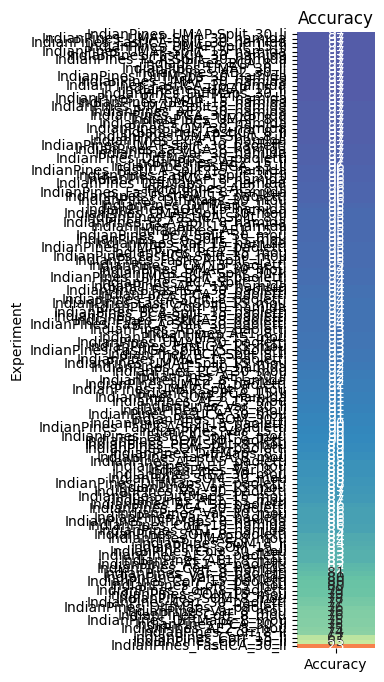

In [17]:
plot_sorted_column_heatmap(df_results[(df_results['Dataset'] == ds)], 'Accuracy')
# dr = 'PCA'
# plot_sorted_column_heatmap(df_results[(df_results['Dataset'] == ds) & (df_results['DR Method'] == dr)],'Accuracy') 

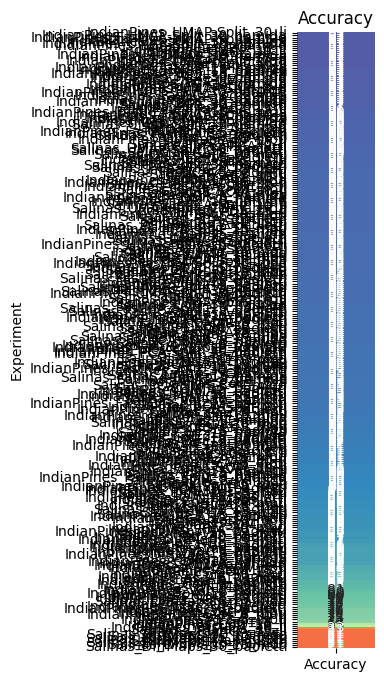

In [18]:
plot_sorted_column_heatmap(df_results,'Accuracy') 

In [19]:
# ds = 'Salinas'
# dr = 'FastICA'
plot_acc_by_model(filter_exp_by_substring(df_results, [f'{ds}_{dr}_8']))


C:\Users\Dell\AppData\Local\Temp\ipykernel_11924\473178509.py:145: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
# ds = 'Salinas'
n_comps = 30

plot_acc_by_model(df_results[(df_results['Dataset'] == ds) ])
                # & (df_results['N Components'] == n_comps)])

C:\Users\Dell\AppData\Local\Temp\ipykernel_11924\473178509.py:145: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## F1 SCORES

In [21]:
# ds = 'Salinas'
# dr = 'PCA'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)], 
                LABELS[ds],
                metric='F1 scores')

In [22]:
ds = 'Salinas'
dr = 'PCA'
model = 'mou'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)
                & (df_results['Model'] ==  model)], 
                LABELS[ds],
                metric='F1 scores')

## IOU SCORES

In [23]:
ds = 'Salinas'
dr = 'FastICA'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)], 
                LABELS[ds],
                metric='IOU')
dr = 'PCA'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)], 
                LABELS[ds],
                metric='IOU')

In [24]:
ds = 'Salinas'
dr = 'PCA'
model = 'li'
plot_grouped_values(df_results[(df_results['Dataset'] == ds) 
                & (df_results['DR Method'] == dr)
                & (df_results['Model'] ==  model)], 
                LABELS[ds],
                metric='IOU')


# ANOVA

In [25]:
df_results[['Experiment', 'IOU', 'Dataset', 'Model', 'DR Method', 'N Components']]

,Experiment,IOU,Dataset,Model,DR Method,N Components
0,Salinas_PCA_8_mou,"[0.0, 0.9527127924340468, 1.0, 0.9954637096774...",Salinas,mou,PCA,8
1,Salinas_PCA_8_hamida,"[0.0, 0.9527127924340468, 1.0, 0.9984840828701...",Salinas,hamida,PCA,8
2,Salinas_PCA_8_li,"[0.0, 0.9527127924340468, 1.0, 0.9994941831057...",Salinas,li,PCA,8
3,Salinas_PCA_8_paoletti,"[0.0, 0.9527127924340468, 1.0, 0.9859296482412...",Salinas,paoletti,PCA,8
4,Salinas_PCA_15_mou,"[0.0, 0.925335988053758, 0.9817508595609628, 0...",Salinas,mou,PCA,15
...,...,...,...,...,...,...
283,IndianPines_UMAP-Split_15_paoletti,"[0.0, 0.9166666666666666, 0.9225260416666666, ...",IndianPines,paoletti,UMAP-Split,15
284,IndianPines_UMAP-Split_30_mou,"[0.0, 0.9787234042553191, 0.9536784741144414, ...",IndianPines,mou,UMAP-Split,30
285,IndianPines_UMAP-Split_30_hamida,"[0.0, 1.0, 0.9993002099370188, 0.9012048192771...",IndianPines,hamida,UMAP-Split,30
286,IndianPines_UMAP-Split_30_li,"[0.0, 1.0, 0.9972067039106145, 0.9036144578313...",IndianPines,li,UMAP-Split,30


In [26]:

print('Comparing Model\'s performances with different Data Reduction methods.')
tests_results = []
for ds in ['Salinas', 'IndianPines']:
    for dr in ['PCA', 'FastICA', 'UMAP', 'SOM', 'Var', 'Corr', 'AE1', 'AE2']:
        print(f'\n-> {ds}, {dr}  --------------------------------------------------------------')
        accuracies = accuracies_by_n_comps(df_results, ds, dr)
        ANOVA_result, T_test_results = ANOVA_TTest(accuracies, 
                transposed=False, 
                describe=False, 
                ind_samples=False)
        
        tests_results.append({
            'Dataset': ds, 
            'Data Reduction': dr,
            'ANOVA': ANOVA_result,
            'T Tests': T_test_results
        }
        )

Comparing Model's performances with different Data Reduction methods.

-> Salinas, PCA  --------------------------------------------------------------
ANOVA test -> F-statistic: 1.082078008877013, p-value: 0.41019384324694935
No significant difference in accuracies for ANOVA

Paired T Tests
hamida vs li: t-statistic = -1.3219865697376907, p-value = 0.31711492919903117
hamida vs mou: t-statistic = 1.185344823319659, p-value = 0.3576326651019408
hamida vs paoletti: t-statistic = 1.3433254124867535, p-value = 0.3112983645303824
li vs mou: t-statistic = 1.557077812070841, p-value = 0.2597496135212742
li vs paoletti: t-statistic = 1.8342307123811465, p-value = 0.20805815555153725
mou vs paoletti: t-statistic = 0.06351538933489513, p-value = 0.9551330652953216

No significant difference found with T Tests

-> Salinas, FastICA  --------------------------------------------------------------
ANOVA test -> F-statistic: 0.951656215512751, p-value: 0.46052609395453903
No significant difference in 

In [27]:
df_tests_results = pd.DataFrame.from_dict(tests_results, )
df_tests_results

,Dataset,Data Reduction,ANOVA,T Tests
0,Salinas,PCA,False,[]
1,Salinas,FastICA,False,[]
2,Salinas,UMAP,False,"[li > hamida, mou > hamida, paoletti > hamida,..."
3,Salinas,SOM,False,[hamida > mou]
4,Salinas,Var,False,[]
5,Salinas,Corr,False,[li > hamida]
6,Salinas,AE1,False,[mou > hamida]
7,Salinas,AE2,False,[]
8,IndianPines,PCA,False,[]
9,IndianPines,FastICA,False,"[hamida > mou, paoletti > mou]"


In [28]:

print('Comparing Model\'s performances with different Data Reduction methods.')
tests_results = []
for ds in ['Salinas', 'IndianPines']:
    for dr in ['PCA', 'FastICA', 'UMAP', 'SOM', 'Var', 'Corr']:
        for n_comps in [8, 15, 30]:
            print(f'\n-> {ds}, {dr}, {n_comps} --------------------------------------------------------------')
            scores_df = scores_by_model(df_results, #[df_results['Model'].isin(['mou', 'paoletti'])], 
                                        dataset=ds, 
                                        dr_method=dr, 
                                        n_comps=n_comps,
                                        scores='IOU')
            print(scores_df)
            ANOVA_result, T_test_results = ANOVA_TTest(scores_df, transposed=False)
            
            tests_results.append({
                'Dataset': ds, 
                'Data Reduction': dr,
                'ANOVA': ANOVA_result,
                'T Tests': T_test_results
            }
            )


Comparing Model's performances with different Data Reduction methods.

-> Salinas, PCA, 8 --------------------------------------------------------------
          Class 1   Class 2  Class 3   Class 4   Class 5   Class 6   Class 7  \
Model                                                                          
hamida        0.0  0.952713      1.0  0.998484  0.992115  0.998507  0.984592   
li            0.0  0.952713      1.0  0.999494  0.990674  0.998136  0.984592   
mou           0.0  0.952713      1.0  0.995464  0.982845  0.993680  0.983102   
paoletti      0.0  0.952713      1.0  0.985930  0.973571  0.985926  0.984095   

           Class 8   Class 9  Class 10  Class 11  Class 12  Class 13  \
Model                                                                  
hamida    0.988265  0.996293  0.970785  0.968165  0.970451  0.975983   
li        0.988265  0.996132  0.971960  0.970037  0.970954  0.975983   
mou       0.987147  0.995811  0.967732  0.966324  0.970954  0.975983   
paolet

In [29]:
scores_df = scores_by_model(df_results, #[df_results['Model'].isin(['mou', 'paoletti'])], 
                            dataset=ds, 
                            dr_method=dr, 
                            n_comps=15,
                            scores='IOU')
ANOVA_TTest(scores_df, transposed=False)

ANOVA test -> F-statistic: 0.6764565188368226, p-value: 0.5698627168318521
No significant difference in accuracies for ANOVA

Paired T Tests
hamida vs li: t-statistic = 2.325277410864493, p-value = 0.03449456444051216
hamida vs mou: t-statistic = 1.6650226440094082, p-value = 0.11665092387043799
hamida vs paoletti: t-statistic = 1.4769088506598467, p-value = 0.16038585168093544
li vs mou: t-statistic = -1.9756086326190014, p-value = 0.06689332473465706
li vs paoletti: t-statistic = -1.8540631357190431, p-value = 0.08349819475771453
mou vs paoletti: t-statistic = 0.10349388013713304, p-value = 0.918942042365662


(False, ['hamida > li'])

In [39]:
df_to_save

,Experiment,Confusion matrix,Accuracy,F1 scores,Kappa,IOU,Dataset,DR Method,N Components,Model
0,Salinas_PCA_8_mou,"b""\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...",95.285337,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.947651,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,Salinas,PCA,8,mou
1,Salinas_PCA_8_hamida,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,94.708936,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.941174,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,Salinas,PCA,8,hamida
2,Salinas_PCA_8_li,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,95.701011,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",0.952256,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,Salinas,PCA,8,li
3,Salinas_PCA_8_paoletti,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,95.536589,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.950400,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",Salinas,PCA,8,paoletti
4,Salinas_PCA_15_mou,"b""\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...",88.488611,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.872189,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",Salinas,PCA,15,mou
...,...,...,...,...,...,...,...,...,...,...
283,IndianPines_UMAP-Split_15_paoletti,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,94.796954,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.940844,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",IndianPines,UMAP-Split,15,paoletti
284,IndianPines_UMAP-Split_30_mou,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,95.167903,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.945044,"b""\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...",IndianPines,UMAP-Split,30,mou
285,IndianPines_UMAP-Split_30_hamida,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,97.471691,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.971258,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,IndianPines,UMAP-Split,30,hamida
286,IndianPines_UMAP-Split_30_li,b'\x80\x04\x95\x95\t\x00\x00\x00\x00\x00\x00\x...,97.481453,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,0.971369,b'\x80\x04\x95\x10\x01\x00\x00\x00\x00\x00\x00...,IndianPines,UMAP-Split,30,li


# Statistical Inference with Paired T-Tests


## 2nd Hypothesis - Compare models with the same architecture, different depths


In [36]:
metric = 'IOU'

for ds in ['IndianPines']:
    for paired_models in [['mou', 'paoletti'], ['li', 'hamida']]:
        df_ttest = pd.DataFrame(columns=[8, 15, 30])
        print(f'\n{paired_models[0]} vs {paired_models[1]} - {metric} in {ds}')
        for dr_method in ['PCA', 'FastICA', 'UMAP', 'AE1', 'AE2','PCA-Split', 'FastICA-Split', 'UMAP-Split']:
            diffs = []
            for n_comps in [8, 15, 30]:
                scores_df = scores_by_model(df_results[df_results['Model'].isin(paired_models)], 
                                            dataset=ds, 
                                            dr_method=dr_method, 
                                            n_comps=n_comps,
                                            scores=metric)
                
                diffs.append(paired_t_test(scores_df))
            df_ttest.loc[dr_method] = diffs
        print(df_ttest)





mou vs paoletti - IOU in IndianPines
                     8         15        30
PCA                   =         =       mou
FastICA        paoletti  paoletti  paoletti
UMAP           paoletti         =         =
AE1                   =         =       mou
AE2            paoletti         =         =
PCA-Split             =       mou         =
FastICA-Split         =         =       mou
UMAP-Split     paoletti  paoletti  paoletti

li vs hamida - IOU in IndianPines
                   8       15      30
PCA                 =  hamida  hamida
FastICA             =  hamida  hamida
UMAP                =       =       =
AE1                li      li       =
AE2                li      li       =
PCA-Split           =  hamida  hamida
FastICA-Split       =       =  hamida
UMAP-Split     hamida       =       =


Comparing models with different architectures, but "same" size

In [ ]:
metric = 'IOU'

for ds in ['IndianPines']:
    for paired_models in [['hamida', 'paoletti'], ['li', 'mou']]:
        df_ttest = pd.DataFrame(columns=[8, 15, 30])
        print(f'\n{paired_models[0]} vs {paired_models[1]} - {metric} in {ds}')
        for dr_method in ['PCA', 'FastICA', 'UMAP', 'AE1', 'AE2','PCA-Split', 'FastICA-Split', 'UMAP-Split']:
            diffs = []
            for n_comps in [8, 15, 30]:
                scores_df = scores_by_model(df_results[df_results['Model'].isin(paired_models)], 
                                            dataset=ds, 
                                            dr_method=dr_method, 
                                            n_comps=n_comps,
                                            scores=metric)
                
                diffs.append(paired_t_test(scores_df))
            df_ttest.loc[dr_method] = diffs
        print(df_ttest)





hamida vs paoletti - IOU in IndianPines
                   8       15      30
PCA            hamida  hamida  hamida
FastICA        hamida  hamida  hamida
UMAP           hamida  hamida  hamida
SOM            hamida  hamida  hamida
Var                 =  hamida  hamida
Corr           hamida       =  hamida
AE1                 =  hamida  hamida
AE2            hamida  hamida  hamida
PCA-Split           =  hamida  hamida
FastICA-Split  hamida  hamida  hamida
UMAP-Split     hamida  hamida  hamida

li vs mou - IOU in IndianPines
               8    15   30
PCA            li  mou  mou
FastICA        li   li  mou
UMAP           li   li   li
SOM            li   li   li
Var            li   li   li
Corr            =    =  mou
AE1            li   li   li
AE2            li   li   li
PCA-Split       =    =    =
FastICA-Split  li   li   li
UMAP-Split     li   li   li


In [32]:
ds = 'Salinas'
dr = 'PCA'
n_comps=30
metric = 'IOU'

scores_df = scores_by_model(df_results[df_results['Model'].isin(['li', 'hamida'])], 
                            dataset=ds, 
                            dr_method=dr, 
                            n_comps=n_comps,
                            scores=metric)
scores_df['Mean'] = scores_df.agg('mean', axis=1).values
scores_df

,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,Class 10,Class 11,Class 12,Class 13,Class 14,Class 15,Class 16,Class 17,Mean
Model,,,,,,,,,,,,,,,,,,
hamida,0.0,0.952713,1.0,1.0,0.992109,0.999254,0.984592,0.988265,0.931549,0.996132,0.972561,0.970974,0.971458,0.975983,0.971082,0.874834,0.859989,0.908323
li,0.0,0.952713,1.0,1.0,0.992826,0.999627,0.984592,0.988265,0.940085,0.995811,0.972248,0.970974,0.971458,0.975983,0.971989,0.888132,0.860542,0.909720


In [33]:
accuracies = accuracies_by_n_comps(df_results, ds, dr)
accuracies

N Components,8,15,30
Model,,,
hamida,94.708936,94.991594,96.641357
li,95.701011,95.002679,96.833490
mou,95.285337,88.488611,95.106135
paoletti,95.536589,89.316263,93.912690


# Analyzing classes 

In [34]:
# df = pd.DataFrame(data=df_results['IOU'])
# df
ds = 'Salinas'

df = df_results[df_results['Dataset']==ds].copy()

df = pd.DataFrame(columns=LABELS[ds], data=[val for val in df['IOU'].values], index=df['Experiment'].values)
# df['exp_mean'] = df.agg('mean', axis=1)


#filter experiments that didn't converge

# df = df[df['exp_mean'] > 0.5]
df

,Undefined,Brocoli_green_weeds_1,Brocoli_green_weeds_2,Fallow,Fallow_rough_plow,Fallow_smooth,Stubble,Celery,Grapes_untrained,Soil_vinyard_develop,Corn_senesced_green_weeds,Lettuce_romaine_4wk,Lettuce_romaine_5wk,Lettuce_romaine_6wk,Lettuce_romaine_7wk,Vinyard_untrained,Vinyard_vertical_trellis
Salinas_PCA_8_mou,0.0,0.952713,1.000000,0.995464,0.982845,0.993680,0.983102,0.987147,0.872304,0.995811,0.967732,0.966324,0.970954,0.975983,0.971055,0.798746,0.859989
Salinas_PCA_8_hamida,0.0,0.952713,1.000000,0.998484,0.992115,0.998507,0.984592,0.988265,0.850972,0.996293,0.970785,0.968165,0.970451,0.975983,0.971989,0.748728,0.859513
Salinas_PCA_8_li,0.0,0.952713,1.000000,0.999494,0.990674,0.998136,0.984592,0.988265,0.888680,0.996132,0.971960,0.970037,0.970954,0.975983,0.971082,0.818878,0.859989
Salinas_PCA_8_paoletti,0.0,0.952713,1.000000,0.985930,0.973571,0.985926,0.984095,0.988265,0.890475,0.995650,0.960558,0.929616,0.965446,0.975983,0.972897,0.814762,0.859513
Salinas_PCA_15_mou,0.0,0.925336,0.981751,0.874012,0.927940,0.900256,0.984343,0.951866,0.698493,0.936374,0.778986,0.651297,0.920460,0.823417,0.941976,0.621515,0.596257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Salinas_UMAP-Split_15_paoletti,0.0,0.952239,0.998927,0.998988,0.989964,0.995536,0.984592,0.985758,0.885295,0.990975,0.961585,0.932788,0.970451,0.971739,0.971055,0.820890,0.856669
Salinas_UMAP-Split_30_mou,0.0,0.952239,0.999732,0.990900,0.993544,0.999253,0.984592,0.987147,0.880173,0.996453,0.968712,0.963721,0.970954,0.971739,0.971028,0.807591,0.860542
Salinas_UMAP-Split_30_hamida,0.0,0.952239,1.000000,0.998988,0.991410,0.998134,0.984592,0.987985,0.903656,0.996293,0.972273,0.970974,0.971458,0.975983,0.973832,0.842510,0.860542
Salinas_UMAP-Split_30_li,0.0,0.952239,1.000000,1.000000,0.993544,1.000000,0.984592,0.988265,0.961169,0.996453,0.973764,0.970974,0.971458,0.975983,0.973832,0.920065,0.860542


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

if 'mean' in df.index:
    new_df = df.drop('mean')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(new_df.astype(float), cmap='viridis', annot=True, fmt='.2f', cbar=True)
plt.title('Heatmap of DataFrame')
plt.show()

NameError: name 'new_df' is not defined

<Figure size 1200x800 with 0 Axes>

# LATEX TABLES

In [ ]:
from tabulate import tabulate

# mou vs paoletti - IOU in Salinas
#                8         15        30
# PCA      paoletti         =  paoletti
# FastICA         =  paoletti  paoletti

# li vs hamida - IOU in Salinas
#         8       15      30
# PCA      =       =      li
# FastICA  =  hamida  hamida

# mou vs paoletti - IOU in IndianPines
#         8         15        30
# PCA      =         =         =
# FastICA  =  paoletti  paoletti

# li vs hamida - IOU in IndianPines
#              8       15      30
# PCA           =  hamida  hamida
# FastICA  hamida  hamida  hamida

# Define the DataFrame data
data = {
    8: ['=', '='],
    15: ['=', 'paoletti'],
    30: ['=', 'paoletti']
}


# Define custom row labels
index = ['PCA', 'FastICA']

# Generate the LaTeX code for the table with centered content
table = tabulate(data, headers='keys', tablefmt='latex_raw', showindex=index)

# Add \centering to center the content of each cell
table = "\\begin{table}[h]\n\\caption{Paired T Test of Mou (Shallow RNN) and Paoletti (Deep RNN) on Indian Pines Dataset}\n\\centering\n" + table + "\n\\end{table}"

# Print the LaTeX code
print(table)

\begin{table}[h]
\caption{Paired T Test of Mou (Shallow RNN) and Paoletti (Deep RNN) on Indian Pines Dataset}
\centering
\begin{tabular}{llll}
\hline
         & 8   & 15       & 30       \\
\hline
 PCA     & =   & =        & =        \\
 FastICA & =   & paoletti & paoletti \\
\hline
\end{tabular}
\end{table}
